In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm

%matplotlib inline

In [2]:
import matplotlib as mpl

In [3]:
import vehicleDetection

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load and look at the training data.

In [4]:
images, classes = vehicleDetection.data.getData(numLighter=0, numFlip=0)

HBox(children=(IntProgress(value=0, max=6726), HTML(value='')))

# Train the classifier on the full dataset with the best classifier parameters.

In [5]:
detector = vehicleDetection.detector.Detector()

Got scalar parameter (C). Assuming no CV requested.


In [6]:
%%time
detector.fit(
    images,
    classes,
)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Test Accuracy of clf =  0.988112927192
CPU times: user 1min 19s, sys: 612 ms, total: 1min 19s
Wall time: 1min 19s


# Run the detector on a test image.

In [7]:
testImages = [
    vehicleDetection.data.readImage('test_images/test%d.jpg' % (k+1,))
    for k in range(6)
]

In [8]:
img = testImages[0]

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


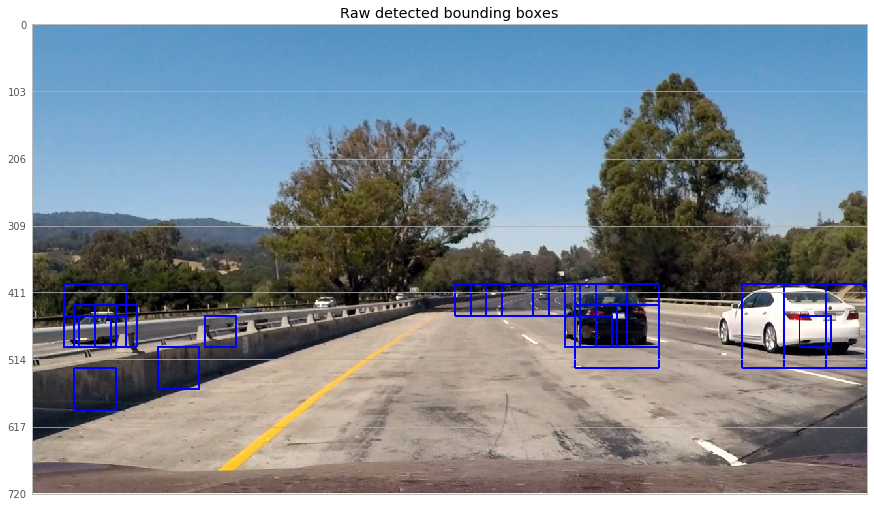

In [9]:
# from IPython.core.debugger import set_trace; set_trace()
ax = detector.drawDetect(img)
ax.set_title('Raw detected bounding boxes')
ax.set_yticks(np.round(np.linspace(0, 720, 8)));

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


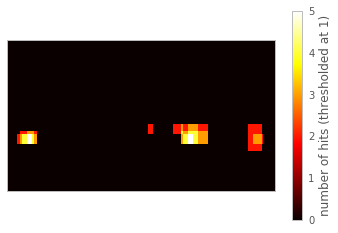

In [10]:
heatmap = detector.heat(img.shape, detector.rawDetect(img))
thr = 1
heatmap[heatmap <= thr] = 0
fig, ax = plt.subplots()
im = ax.imshow(heatmap[:, :, 0], cmap=mpl.cm.hot)
fig.colorbar(im, label='number of hits (thresholded at %d)' % thr)
ax.set_xticks([])
ax.set_yticks([]);

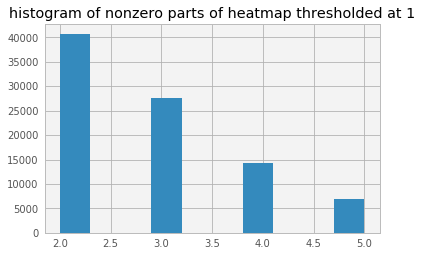

In [11]:
fig, ax = plt.subplots()
nz = heatmap[heatmap>0]
ax.hist(nz.ravel());
ax.set_title('histogram of nonzero parts of heatmap thresholded at %d' % thr);

In [12]:
print('Number of support vectors for each class:', detector.clf.n_support_)

Number of support vectors for each class: [681 619]


/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


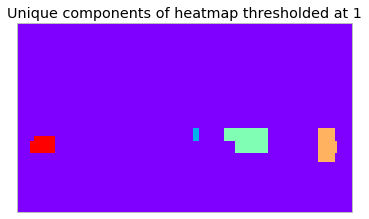

In [13]:
labels = detector.detect(img, threshold=thr)[0][:, :, 0]
fig, ax = plt.subplots()
ax.imshow(labels, cmap=mpl.cm.rainbow)
ax.set_xticks([])
ax.set_yticks([]);
ax.set_title('Unique components of heatmap thresholded at %d' % thr);

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


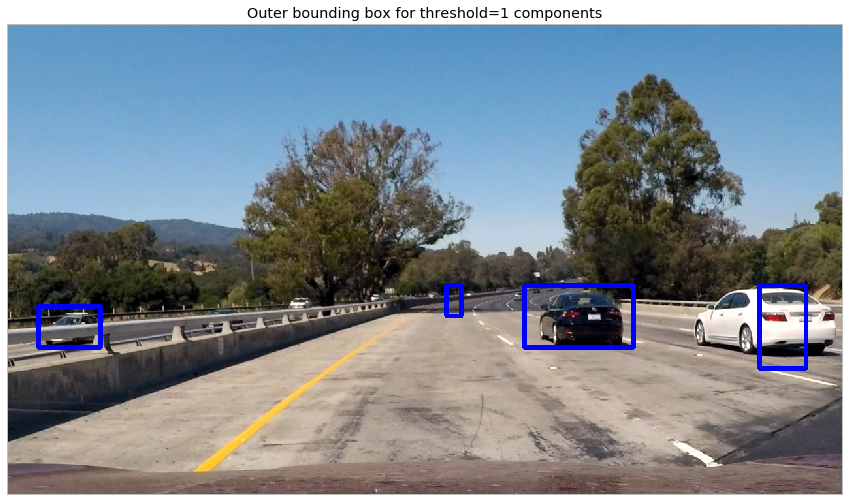

In [14]:
import os
ax = detector.drawHeat(img, threshold=thr)
ax.set_title('Outer bounding box for threshold=%d components' % thr)

In [15]:
import time
import skvideo.io
from IPython.display import HTML

def loadVideo(
    fpath='../../../data/vehicleDetection/test_video.mp4', 
    maxFrames=None, 
    pbar=True
):
    reader = skvideo.io.FFmpegReader(fpath)
    frames = []
    actualMaxFrames = reader.inputframenum if maxFrames is None else maxFrames
    if pbar:
        bar = tqdm.tqdm_notebook(
            total=actualMaxFrames,
            desc='%s' % os.path.basename(fpath),
        )
        update = bar.update
    else:
        update = lambda : None

    for frame in reader.nextFrame():
        if len(frames) == actualMaxFrames:
            break
        update()
        frames.append(frame)
    return frames


def fig2img(fig):
    """Render a Matplotlib figure to an image; good for simple video-making."""
    # stackoverflow.com/questions/35355930
    from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
    from matplotlib.figure import Figure

    canvas = FigureCanvas(fig)
    ax = fig.gca()
    canvas.draw()       # draw the canvas, cache the renderer
    width, _ = fig.get_size_inches() * fig.get_dpi()
    width = int(width)
    image = np.fromstring(canvas.tostring_rgb(), dtype='uint8').reshape(-1, width, 3)
    return image


def saveVideo(frames, fpath, **tqdmKw):
    """Save a collection of images to a video file. I've tried .mp4 extensions."""
    if tqdmKw.pop('pbar', True):
        tqdmKw.setdefault('desc', os.path.basename(fpath))
        tqdmKw.setdefault('unit', 'frame')
        pbar = tqdm.tqdm_notebook
    else:
        pbar = lambda x, **kw: x
    writer = skvideo.io.FFmpegWriter(fpath)
    for frame in pbar(frames, **tqdmKw):
        writer.writeFrame(frame)
    writer.close()
    return showAsHTML(fpath)


def showAsHTML(fpath):
    """Display a video as a Jupyter HTML widget.

    Use a relative path that is accessible via the jupyter notebook webserver.
    """
    # Add a time argument to suggest that chrome shouldn't cache the video.
    t = time.time()

    # Display images with <image>.
    for ext in '.png', '.gif', '.jpg', '.jpeg':
        if fpath.lower().endswith(ext):
            if fpath.lower().endswith('.gif'):
                return jupyterTools.GIFforLatex(fpath)
            else:
                return HTML("""<image src="%s?time=%s" />""" % (fpath, t))

    # Displaly videos with <video>.
    return HTML("""
    <video width=100%% controls loop>
      <source src="%s?time=%s" type="video/mp4">
    </video>
    """ % (fpath, t))


In [16]:
import os

class DetectedVideo:
    
    def __init__(
        self, 
        fpath='../../../data/vehicleDetection/test_video.mp4',
        thr=1,
        **loadKwargs
    ):
        loadKwargs.setdefault('pbar', False)
        self.fpath = fpath
        self.inputFrames = loadVideo(fpath=self.fpath, **loadKwargs)
        self.thr = thr
        
    def go(self):
        
        self.detectedFrames = []
        
        fig, ax = plt.subplots()
        for frame in tqdm.tqdm_notebook(self.inputFrames, desc='predicting', unit='frame'):
            detector.drawHeat(frame, threshold=self.thr, ax=ax)
            self.detectedFrames.append(fig2img(fig))
            ax.cla()
            
        return saveVideo(
            self.detectedFrames,
            'doc/%s-detected.mp4' % os.path.basename(self.fpath).replace('.mp4', '')
        )

HBox(children=(IntProgress(value=0, description='predicting: ', max=38), HTML(value='')))

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


HBox(children=(IntProgress(value=0, description='test_video-detected.mp4: ', max=38), HTML(value='')))

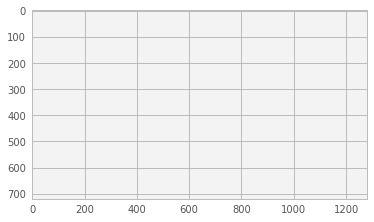

In [ ]:
test = DetectedVideo()
test.go()

In [ ]:
test = DetectedVideo(
    fpath='../../../data/vehicleDetection/project_video.mp4',
)
test.go()

HBox(children=(IntProgress(value=0, description='predicting: ', max=1260), HTML(value='')))

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
